# Data Preprocessing

In [ ]:
#Importing packages for necessary purposes

import numpy as np
import keras 
import pandas as pd
import tensorflow as tf
import re
import nltk

from numpy import array
from numpy import asarray
from numpy import zeros
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from nltk.corpus import stopwords
from keras.regularizers import l2

from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier


In [ ]:
#Importing data
imdb_data = pd.read_csv('IMDB Dataset.csv')
imdb_data.isnull().values.any()
print (imdb_data.shape)
imdb_data.head(10)

(50000, 2)


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


In [ ]:
#cleaning reviews
def review_text(sen):
    # Removing html tags
    sentence = remove_tags(sen)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

In [ ]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

In [ ]:
X = []
sentences = list(imdb_data['review'])
for sen in sentences:
    X.append(review_text(sen))

In [ ]:
#converting positive to 1 and negative to 0
Y = imdb_data['sentiment']

Y = np.array(list(map(lambda x: 1 if x=="positive" else 0, Y)))

In [ ]:
seed=42
np.random.seed(seed)

In [ ]:
#shuffle data
idx = np.arange(len(X))
np.random.shuffle(idx)
X_temp, Y_train = np.array(X)[idx], Y[idx]
X_train = []
for sen in X_temp:
    X_train.append(sen)

In [ ]:
#splitting the data into 70:30 train:test
X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, test_size=0.30, random_state=42)
# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.30, random_state=42)
print(len(X_train))
print(len(X_test))

35000
15000


In [ ]:
#Tokenization of text
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [ ]:
# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1

#cutoff word length per review
maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [ ]:
vocab_size

87633

In [ ]:
#dictionary
embeddings_dictionary = dict()
glove_file = open('glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [ ]:
embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

# Finding Optimal No. of Hidden Layers

In [ ]:
#define params for model
NUM_CLASSES = 1 #positive or negative

epochs = 100

lr = 1e-5 #learning rate
beta = 1e-12 #weight decay param
batch_size = 64
hidden_neurons = 10 #optimal

In [ ]:
#create model and pass in hidden_layers as argument
def create_model(hidden_layers=1):
    model = Sequential()
    embedding_layer = Embedding(vocab_size, 100, weights = [embedding_matrix], 
                                input_length = maxlen, trainable = False)
    model.add(embedding_layer)
    #flatten embedded layers output to to 1 dimension
    model.add(Flatten())

    for i in range(hidden_layers):
      #add dropout
      model.add(Dropout(0.5))
      #hidden layer with 10 hidden neurons, relu activation, l2 regulariation
      model.add(Dense(hidden_neurons, activation = 'relu', kernel_regularizer=l2(beta)))
    
    #output layer with 1 neuron, sigmoid activation, l2 regularisation
    model.add(Dense(NUM_CLASSES, activation = 'sigmoid', kernel_regularizer=l2(beta)))
    
    optimizer = keras.optimizers.Adam(learning_rate=lr)
    
    model.compile(optimizer = optimizer,
                 loss = 'binary_crossentropy',
                 metrics=['accuracy'])
   
    return model

In [ ]:
#wrap keras model
model = KerasClassifier(build_fn=create_model, epochs=epochs, batch_size=batch_size, verbose=2)

#define search space for hidden layers
hidden_layers = [1,2,3,4,5]

#gridsearch for different number of hidden layers
param_grid = dict(hidden_layers=hidden_layers)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=5, verbose=1)
grid_result = grid.fit(X_train, Y_train)

#print results
print('Best Mean Test Accuracy: %f %s'% (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
mean_time = grid_result.cv_results_['mean_fit_time']
params = grid_result.cv_results_['params']
for mean, stdev, time, param in zip(means, stds, mean_time, params):
    print("%r Accuracy: %f(%f), Time: %f" % (param, mean, stdev, time))

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed: 185.3min finished


Epoch 1/100
547/547 - 6s - loss: 0.7092 - accuracy: 0.5082
Epoch 2/100
547/547 - 6s - loss: 0.6935 - accuracy: 0.5175
Epoch 3/100
547/547 - 6s - loss: 0.6923 - accuracy: 0.5257
Epoch 4/100
547/547 - 6s - loss: 0.6889 - accuracy: 0.5374
Epoch 5/100
547/547 - 6s - loss: 0.6859 - accuracy: 0.5423
Epoch 6/100
547/547 - 6s - loss: 0.6762 - accuracy: 0.5666
Epoch 7/100
547/547 - 6s - loss: 0.6678 - accuracy: 0.5889
Epoch 8/100
547/547 - 6s - loss: 0.6580 - accuracy: 0.6076
Epoch 9/100
547/547 - 6s - loss: 0.6485 - accuracy: 0.6203
Epoch 10/100
547/547 - 6s - loss: 0.6429 - accuracy: 0.6300
Epoch 11/100
547/547 - 6s - loss: 0.6354 - accuracy: 0.6397
Epoch 12/100
547/547 - 6s - loss: 0.6286 - accuracy: 0.6484
Epoch 13/100
547/547 - 6s - loss: 0.6217 - accuracy: 0.6569
Epoch 14/100
547/547 - 6s - loss: 0.6180 - accuracy: 0.6607
Epoch 15/100
547/547 - 6s - loss: 0.6139 - accuracy: 0.6636
Epoch 16/100
547/547 - 6s - loss: 0.6101 - accuracy: 0.6695
Epoch 17/100
547/547 - 6s - loss: 0.6063 - accura

# Train model with optimal number of hidden layers = 1

In [ ]:
#define params for model
NUM_CLASSES = 1 #positive or negative

epochs = 100

lr = 1e-5 #optimal learning rate
beta = 1e-12 #optimal weight decay param
batch_size = 64 #optimal
hidden_neurons = 10

In [ ]:
#create model with dropouts
def create_model():
    model = Sequential()
    embedding_layer = Embedding(vocab_size, 100, weights = [embedding_matrix], 
                                input_length = maxlen, trainable = False)
    model.add(embedding_layer)
    #flatten embedded layers output to to 1 dimension
    model.add(Flatten())
    
    #add dropout
    model.add(Dropout(0.5))
    #one hidden layer with 10 hidden neurons, relu activation, l2 regulariation
    #output layer with 1 neuron, sigmoid activation, l2 regularisation
    model.add(Dense(hidden_neurons, activation = 'relu', kernel_regularizer=l2(beta)))
    model.add(Dense(NUM_CLASSES, activation = 'sigmoid', kernel_regularizer=l2(beta)))
    
    optimizer = keras.optimizers.Adam(learning_rate=lr)
    
    model.compile(optimizer = optimizer,
                 loss = 'binary_crossentropy',
                 metrics=['accuracy'])
   
    return model

In [ ]:
#train model
model = create_model()
history = model.fit(X_train, Y_train,
                    epochs = epochs,
                    verbose = 2,
                    batch_size = batch_size,
                    validation_data = (X_test, Y_test)
                   )

Epoch 1/100
547/547 - 2s - loss: 0.7223 - accuracy: 0.5121 - val_loss: 0.6879 - val_accuracy: 0.5425
Epoch 2/100
547/547 - 2s - loss: 0.6920 - accuracy: 0.5321 - val_loss: 0.6855 - val_accuracy: 0.5623
Epoch 3/100
547/547 - 2s - loss: 0.6856 - accuracy: 0.5534 - val_loss: 0.6779 - val_accuracy: 0.5839
Epoch 4/100
547/547 - 2s - loss: 0.6776 - accuracy: 0.5746 - val_loss: 0.6676 - val_accuracy: 0.6111
Epoch 5/100
547/547 - 2s - loss: 0.6699 - accuracy: 0.5866 - val_loss: 0.6584 - val_accuracy: 0.6273
Epoch 6/100
547/547 - 2s - loss: 0.6594 - accuracy: 0.6062 - val_loss: 0.6495 - val_accuracy: 0.6417
Epoch 7/100
547/547 - 2s - loss: 0.6527 - accuracy: 0.6168 - val_loss: 0.6425 - val_accuracy: 0.6499
Epoch 8/100
547/547 - 2s - loss: 0.6452 - accuracy: 0.6256 - val_loss: 0.6354 - val_accuracy: 0.6566
Epoch 9/100
547/547 - 2s - loss: 0.6381 - accuracy: 0.6365 - val_loss: 0.6288 - val_accuracy: 0.6611
Epoch 10/100
547/547 - 2s - loss: 0.6302 - accuracy: 0.6464 - val_loss: 0.6211 - val_accura

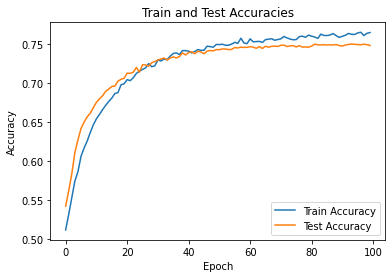

In [ ]:
#Summarize history for accuracy
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.title('Train and Test Accuracies')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc="lower right")
plt.show()